# **Load libraries and dataset**

---



In [0]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [0]:
# load data
bike_rental = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0103/day.csv")

# Exploratory data anamysis

---



**A Short description of the features**

* **instant**: Record index
* **dteday**: Date
* **season**: Season 
    1. springer 
    2. summer 
    3. fall
    4. winter
* **yr**: Year (0: 2011, 1:2012)
* **mnth**: Month (1 to 12)
* **holiday**: weather day is holiday or not (extracted fromHoliday Schedule)
* **weekday**: Day of the week
* **workingday**: If day is neither weekend nor holiday is 1, otherwise is 0.
* **weathersit**: (extracted fromFreemeteo)
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain +       Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **temp**: Normalized temperature in Celsius. The values are derived via
       (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* **atemp**: Normalized feeling temperature in Celsius. The values are derived via
       (t-t_min)/(t_maxt_min), t_min=-16, t_max=+50 (only in hourly scale)
* **hum**: Normalized humidity. The values are divided to 100 (max)
* **windspeed**: Normalized wind speed. The values are divided to 67 (max)
* **casual**: count of casual users
* **registered**: count of registered users
* **cnt**: count of total rental bikes including both casual and registered

In [0]:
# First let denormalize our dataset for EDA
# for temp and atemp we'll use below formula 
# y^ = y^ norm× * (maxY−minY) + minY
# for temp given values are
#  t_min=-8, t_max=+39
bike_rental['temp'] = (bike_rental['temp'] * (39 - (-8))) + (-8)

# for atemp given values are
# t_min=-16, t_max=+50
bike_rental['atemp'] = (bike_rental['atemp'] * (50 - (-16))) + (-16)

# for hum given values was divided by 100
# So, we can calculate actual values by multiply with 100
bike_rental['hum'] = bike_rental['hum'] * 100

# for windspeed given values was divided by 67
# So, we can calculate actual values by multiply with 67
bike_rental['windspeed'] = bike_rental['windspeed'] * 67


In [5]:
# view few random records
bike_rental.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
573,574,2012-07-27,3,1,7,0,5,1,1,28.738349,32.458322,59.4583,10.250464,1259,5645,6904
192,193,2011-07-12,3,0,7,0,2,1,1,29.325849,32.792150,55.9167,13.417018,662,3596,4258
535,536,2012-06-19,2,1,6,0,2,1,1,24.351651,27.209672,69.0000,9.917139,968,5857,6825
71,72,2011-03-13,1,0,3,0,0,0,1,10.064356,9.086006,52.7391,18.130468,982,1435,2417
479,480,2012-04-24,2,1,4,0,2,1,1,11.426651,10.748678,45.4167,16.708661,518,5115,5633


In [6]:
# view shape of data
bike_rental.shape

(731, 16)

In [9]:
# check sum of casual + registered = cnt
bike_rental.iloc[1:5, 13:16]

,casual,registered,cnt
1,131,670,801
2,120,1229,1349
3,108,1454,1562
4,82,1518,1600


In [0]:
# It seems that cnt variable is addition of casual and registered variable
# We can remove casual and registered variable
# remove unnecessary variables like instant and dteday which are not fruiful for model 
bike_rental.drop(labels=['instant','dteday','casual','registered'], axis = 1, inplace=True)

In [11]:
# dataset information
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
cnt           731 non-null int64
dtypes: float64(4), int64(8)
memory usage: 68.7 KB


In [12]:
# dataset summary with min,max,mean,std etc statistics
bike_rental.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,15.283085,15.307363,62.789406,12.762576,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,8.603397,10.755438,14.242910,5.192357,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-5.220871,-10.781406,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,7.842925,6.297605,52.000000,9.041650,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,15.421651,16.124378,62.666700,12.125325,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,22.804575,24.167732,73.020850,15.625371,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,32.498349,39.499136,97.250000,34.000021,8714.000000


# **Univariant analysis**

---



Text(0, 0.5, 'Frequency')

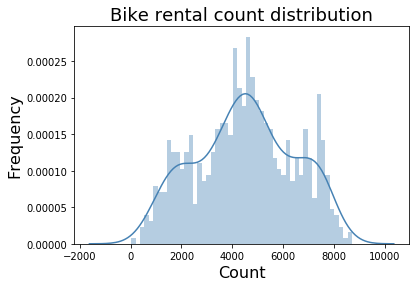

In [12]:
# distribution plot of count
sns.distplot(bike_rental['cnt'],bins=50, color='steelblue')
plt.title('Bike rental count distribution', fontsize=18)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

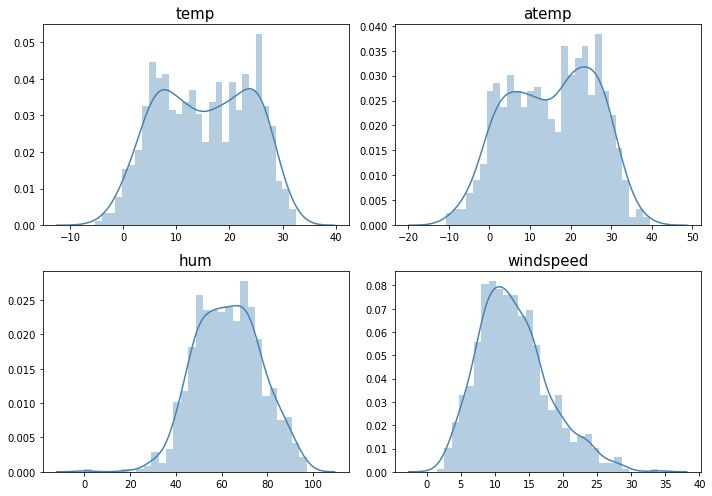

In [13]:
# distribution plot of temp,atemp,hum,windspeed
column_names = ['temp','atemp','hum','windspeed']
fig, axes = plt.subplots(2,2,figsize = (10,5))
count = 0
for row in range(2):
    for col in range(2):
        c_name = column_names[count+col] if count == 0 else column_names[count+col + 1]
        sns.distplot(bike_rental[c_name].values, ax = axes[row][col],bins = 30,color='steelblue', kde = True)
        axes[row][col].set_title(c_name,fontsize=15)
        fig=plt.gcf()
        fig.set_size_inches(10,7)
        plt.tight_layout()
    count = count+col    



---

# **Bivariate analysis**

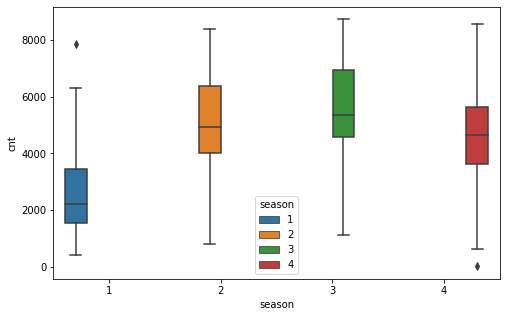

In [14]:
# bike rental count by season
plt.figure(figsize=(8,5))
sns.boxplot(x='season',y='cnt',data=bike_rental,hue='season')

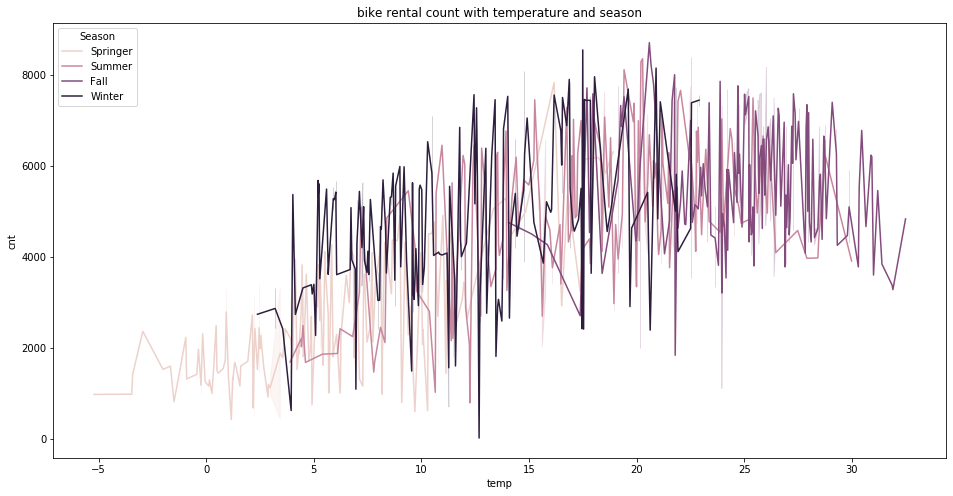

In [17]:
# bike rental count with temperature and season
plt.figure(figsize=(16,8))
g = sns.lineplot(x='temp',y='cnt', data=bike_rental,hue='season')

# label names
new_labels = ['Springer', 'Summer','Fall','Winter']
plt.legend(title='Season', loc='upper left', labels=new_labels)
plt.title('bike rental count with temperature and season')
plt.show(g)

Text(0.5, 1.0, 'bike rental count with humidity and season')

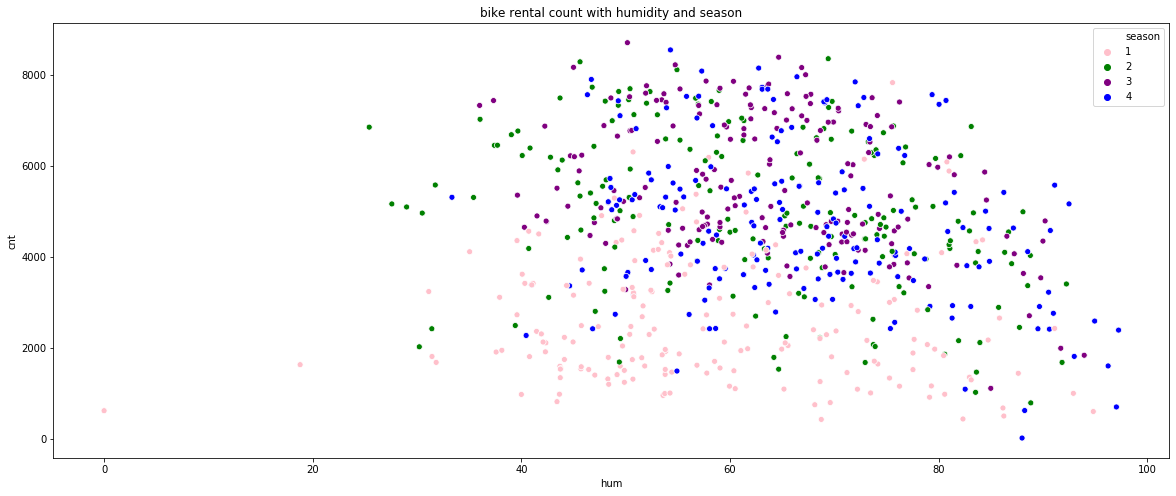

In [16]:
# bike rental count with humidity and season
plt.figure(figsize=(20,8))

sns.scatterplot(x='hum',y='cnt',data=bike_rental,hue='season',palette=['pink','green','purple','blue'])
plt.title('bike rental count with humidity and season')

Text(0.5, 1.0, 'Scatterplot between temperature and count')

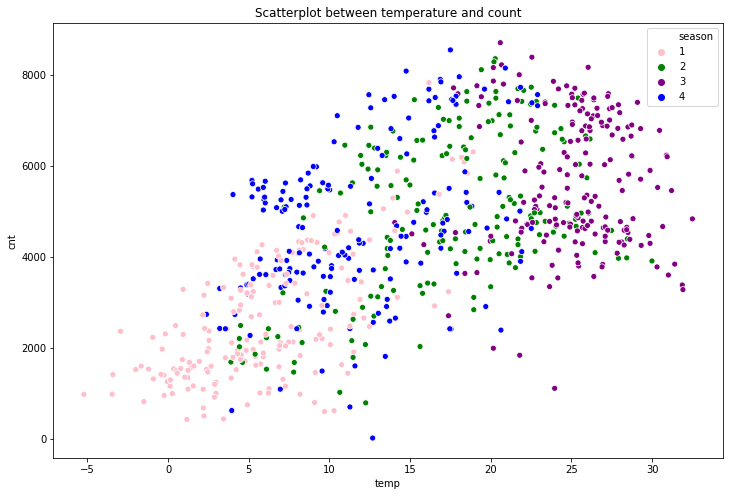

In [18]:
# check linear relationship between temperature and count
plt.figure(figsize=(12,8))
sns.scatterplot(x='temp',y='cnt',data=bike_rental,hue='season',palette=['pink','green','purple','blue'])
plt.title('Scatterplot between temperature and count')

Text(0.5, 1.0, 'Bike rental count by temp and weather')

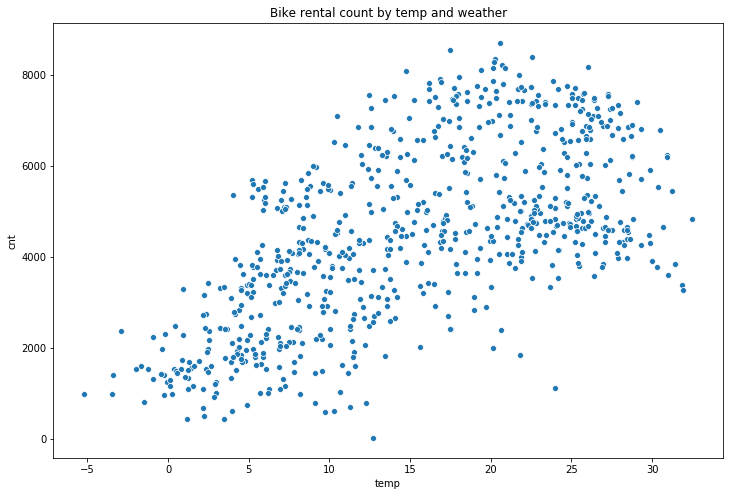

In [45]:
# check linear relationship between temperature and count
plt.figure(figsize=(12,8))
sns.scatterplot(x='temp',y='cnt',data=bike_rental)
plt.title('Bike rental count by temp')

Text(0.5, 1.0, 'Bike rental count relation between temp and atemp')

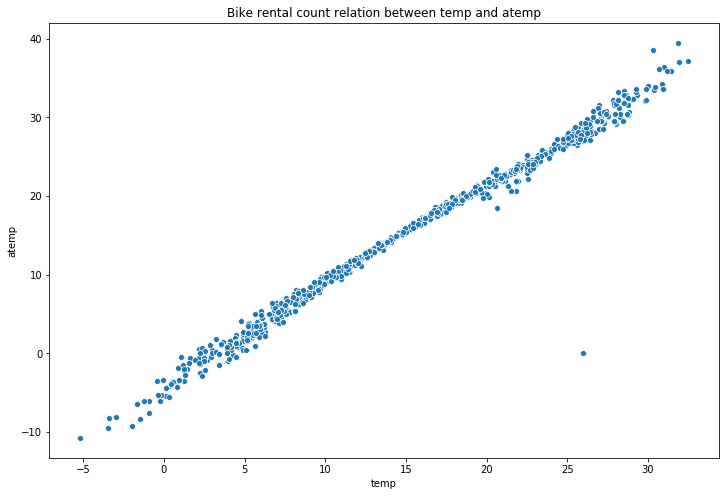

In [46]:
# check linear relationship between temperature and count
plt.figure(figsize=(12,8))
sns.scatterplot(x='temp',y='atemp',data=bike_rental)
plt.title('Bike rental count relation between temp and atemp')

Text(0.5, 1.0, 'Bike rental count Vs humidity')

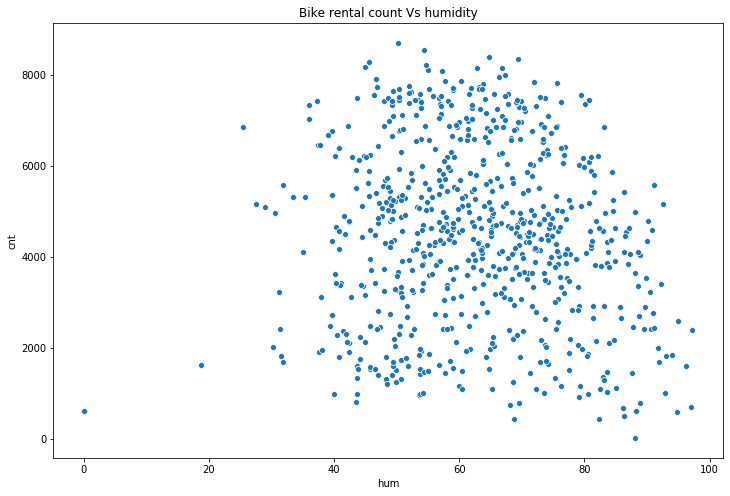

In [19]:
# check linear relationship between temperature and count
plt.figure(figsize=(12,8))
sns.scatterplot(x='hum',y='cnt',data=bike_rental)
plt.title('Bike rental count Vs humidity')

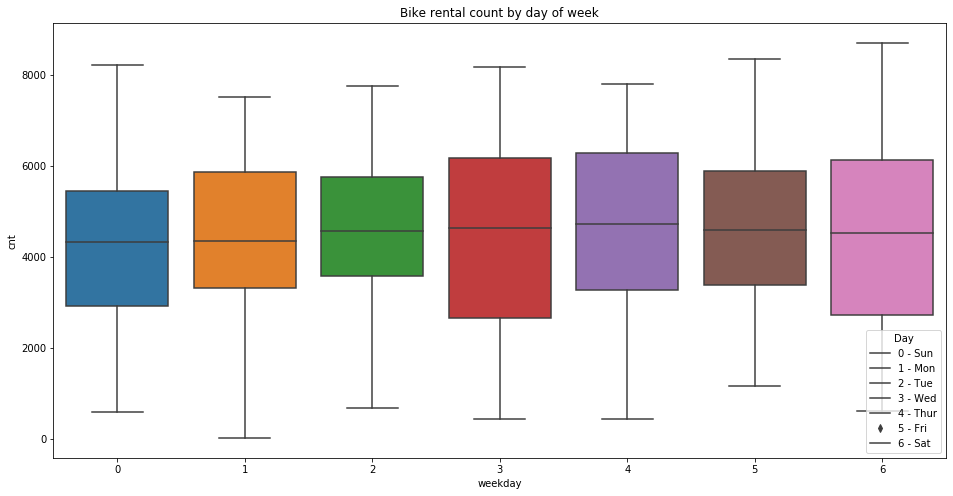

In [21]:
# bike rental count by day of week
plt.figure(figsize=(16,8))
g = sns.boxplot(x='weekday',y='cnt', data=bike_rental)

# label names
new_labels = ['0 - Sun', '1 - Mon','2 - Tue','3 - Wed','4 - Thur','5 - Fri','6 - Sat']
plt.legend(title='Day', loc='lower right', labels=new_labels)
plt.title('Bike rental count by day of week')
plt.show(g)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1, 'Bike rental count by Holiday and Non-holiday')

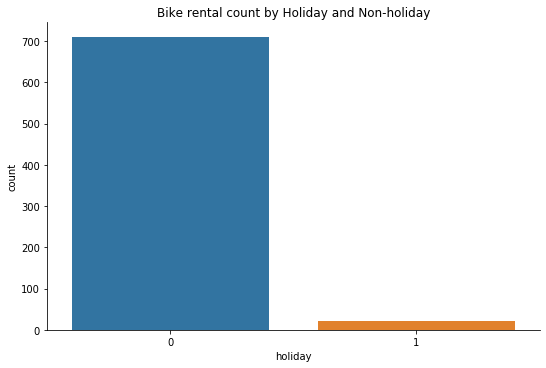

In [22]:
# Bike rental count by Holiday and Non-holiday
sns.catplot(x='holiday', data = bike_rental, kind='count',aspect=1.5, size=5)
plt.title('Bike rental count by Holiday and Non-holiday')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1, 'Bike rental count by Weather')

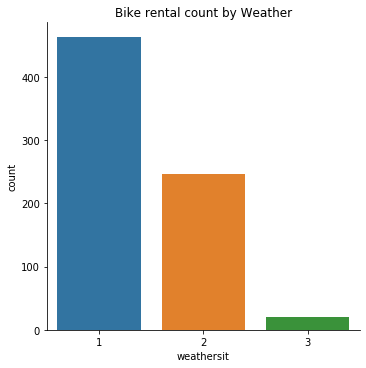

In [23]:
# Bike rental count by Weather
sns.catplot(x='weathersit', data = bike_rental, kind='count',size=5,aspect=1)
plt.title('Bike rental count by Weather')

Text(0.5, 1, 'Bike rental count by WorkingDay and Non-working day')

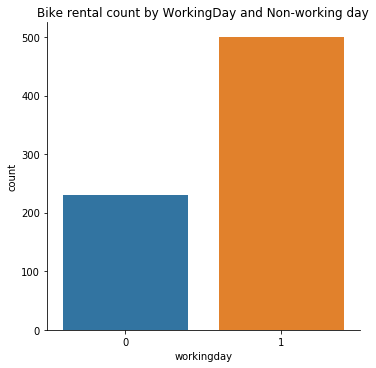

In [24]:
# Bike rental count by WorkingDay and Non-working day
sns.catplot(x='workingday', data = bike_rental ,kind='count')
plt.title('Bike rental count by WorkingDay and Non-working day')

Text(0.5, 1, 'Bike rental count by year')

<Figure size 1152x576 with 0 Axes>

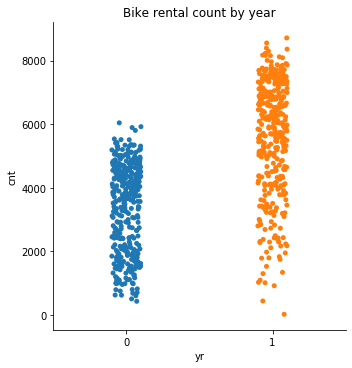

In [25]:
# Bike rental count by year
plt.figure(figsize=(16,8))
sns.catplot(x ='yr',y ='cnt', data = bike_rental)
plt.title('Bike rental count by year')

# **Missing Value analysis**

---




In [26]:
# check missing values
bike_rental.isna().sum().sort_values(ascending=False)

cnt           0
windspeed     0
hum           0
atemp         0
temp          0
weathersit    0
workingday    0
weekday       0
holiday       0
mnth          0
yr            0
season        0
dtype: int64

**In our dataset we don't have any missing values so no need to do further process for missing value analysis**

---





---
# **Outlier Analysis**

Text(0.5, 1.0, 'Outlier analysis of continous variable')

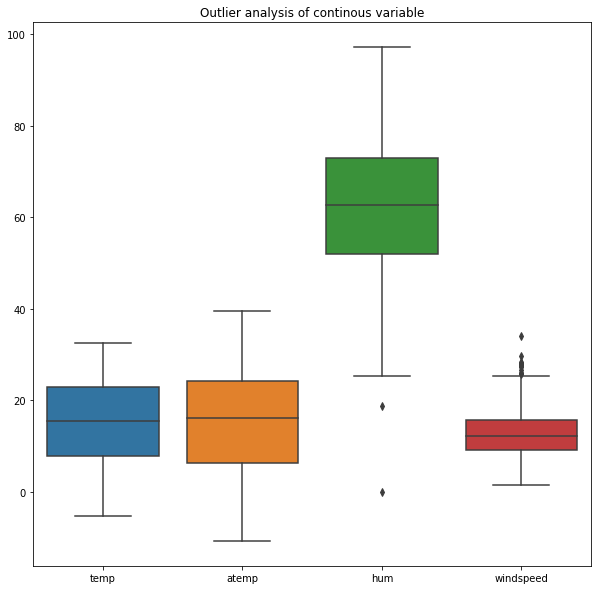

In [15]:
# Outlier analysis of continous variable
col_names = ['temp','atemp', 'hum', 'windspeed']
sns.boxplot(data=bike_rental[col_names])
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.title('Outlier analysis of continous variable')

In [0]:
# Detect outliers and replace with NA
def detect_outlier(col_names):
  for i in col_names:
    column_name = i
    print(column_name)

    # find inter-quartile range
    q75, q25 = np.percentile(bike_rental.loc[:,i], [75,25])
    iqr = q75 - q25

    # find lower and upper fence
    lower_fence = round(q25 - (1.5*iqr),4)
    upper_fence = round(q75 + (1.5*iqr),4)
    print('lower_fence :', lower_fence)
    print('upper_fence :', upper_fence)

    # count outliers
    lower_outlier = bike_rental.loc[bike_rental[column_name] < lower_fence].shape[0]
    upper_outlier = bike_rental.loc[bike_rental[column_name] > upper_fence].shape[0]
    print('No of outlier in variable# ' + str(column_name) + " - " ,  lower_outlier + upper_outlier)

    # delete outlier 
    bike_rental.drop(bike_rental[bike_rental.loc[:,column_name] < lower_fence].index, inplace=True)
    bike_rental.drop(bike_rental[bike_rental.loc[:,column_name] > upper_fence].index, inplace=True)


In [17]:
detect_outlier(col_names)

temp
lower_fence : -14.5996
upper_fence : 45.2471
No of outlier in variable# temp -  0
atemp
lower_fence : -20.5076
upper_fence : 50.9729
No of outlier in variable# atemp -  0
hum
lower_fence : 20.4687
upper_fence : 104.5521
No of outlier in variable# hum -  2
windspeed
lower_fence : -0.8329
upper_fence : 25.4992
No of outlier in variable# windspeed -  12


In [18]:
bike_rental.shape

(717, 12)



---


# **Feature selection**

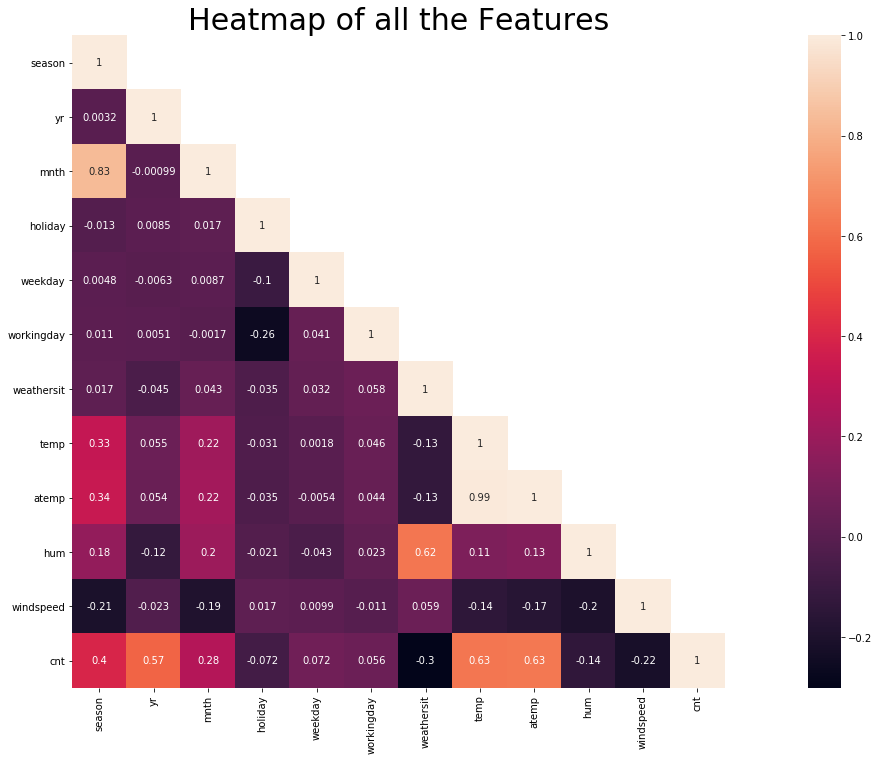

In [19]:
# pairwise correlation
# plot heatmap
cor_mat= bike_rental[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

In [0]:
# Calculate correlation coefficient
def calculate_correlation(df) : 
  # sorted correlations coefficient values
  df_train_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
  df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
  df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)

  df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

  #  return correlations is high
  corr = df_train_corr_nd['Correlation Coefficient'] > 0.5
  return df_train_corr_nd[corr]

In [21]:
# call function
calculate_correlation(bike_rental)

,Feature 1,Feature 2,Correlation Coefficient
12,atemp,temp,0.991738
14,mnth,season,0.833542
16,atemp,cnt,0.629204
18,cnt,temp,0.625892
20,weathersit,hum,0.624584
22,yr,cnt,0.573797


In [0]:
# Calculate VIF function
def calculate_VIF(df):
  X = add_constant(df)
  return pd.DataFrame({'column_name':X.columns, 'VIF':[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})

In [23]:
# call function
calculate_VIF(bike_rental)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,column_name,VIF
0,const,65.571270
1,season,3.964152
2,yr,2.407533
3,mnth,3.391492
4,holiday,1.097197
5,weekday,1.048542
6,workingday,1.079617
7,weathersit,2.021059
8,temp,63.979299
9,atemp,65.168760


In [0]:
# VIF values for temp and atemp are very high
# So, we can drop one variable from these two
# drop atemp and season
bike_rental.drop(columns=['atemp'], inplace=True)

In [25]:
# view few sample records after all the pre-process data
bike_rental.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,8.175849,80.5833,10.749882,985
1,1,0,1,0,0,0,2,9.083466,69.6087,16.652113,801
2,1,0,1,0,1,1,1,1.229108,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,1.400000,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,2.666979,43.6957,12.522300,1600
5,1,0,1,0,4,1,1,1.604356,51.8261,6.000868,1606
6,1,0,1,0,5,1,2,1.236534,49.8696,11.304642,1510
7,1,0,1,0,6,0,2,-0.245000,53.5833,17.875868,959
8,1,0,1,0,0,0,1,-1.498349,43.4167,24.250650,822
9,1,0,1,0,1,1,1,-0.910849,48.2917,14.958889,1321




---



---


# **Features scaling**

In [0]:
# Now. before moving to build model we need to rescale features
# for temp given values are
#  t_min=-8, t_max=+39
bike_rental['temp'] = (bike_rental['temp'] - (-8)) / (39 - (-8)) 

# for hum divide values by 100
bike_rental['hum'] = bike_rental['hum'] / 100

# for windspeed divide values by 67
bike_rental['windspeed'] = bike_rental['windspeed'] / 67


In [27]:
bike_rental.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600
5,1,0,1,0,4,1,1,0.204348,0.518261,0.089565,1606
6,1,0,1,0,5,1,2,0.196522,0.498696,0.168726,1510
7,1,0,1,0,6,0,2,0.165000,0.535833,0.266804,959
8,1,0,1,0,0,0,1,0.138333,0.434167,0.361950,822
9,1,0,1,0,1,1,1,0.150833,0.482917,0.223267,1321


# **Model Development**

---



In [0]:
# Calculate MAPE function
def mape(act_val,pred_val) :
    mape = np.mean(np.abs((act_val - pred_val)/act_val)) * 100
    return mape

In [0]:
# Calculate MAE function
def mae(actual_val,predicted_val):
  return np.mean(np.abs(actual_val - predicted_val))

In [0]:
# Split data into train and test
# assign all the independent variables to X
# assign dependent variable to y
X = bike_rental.drop(columns=['cnt'])
y = bike_rental['cnt']

# Spit data into train 80% and test 20% 
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)

In [31]:
print('train data with independent variables : ',X_train.shape)
print('train data without independent variables : ',y_train.shape)
print('test data with independent variables : ',X_test.shape)
print('test data without independent variables : ',y_test.shape)

train data with independent variables :  (573, 10)
train data without independent variables :  (573,)
test data with independent variables :  (144, 10)
test data without independent variables :  (144,)




---

# **Multiple linear regression**

In [0]:
# build multiple linear regression model
# used stats model api 
linear_reg_model = sm.OLS(y_train,X_train).fit()

In [33]:
# View model summary
linear_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              1668.
Date:                Sat, 07 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:37:11   Log-Likelihood:                         -4701.6
No. Observations:                 573   AIC:                                      9423.
Df Residuals:                     563   BIC:                                      9467.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season       501.3112     63.480      7.897      0.000     376.624     625.998
yr          2168.3079     73.667     29.434      0.000    2023.613    2313.003
mnth         -30.0943     19.918     -1.511      0.131     -69.217       9.028
holiday     -257.5053    222.399     -1.158      0.247    -694.338     179.328
weekday      111.7335     18.450      6.056      0.000      75.495     147.972
workingday   322.4296     82.505      3.908      0.000     160.374     484.485
weathersit  -723.4500     91.852     -7.876      0.000    -903.865    -543.035
temp        5366.3235    217.210     24.706      0.000    4939.682    5792.965
hum          405.5903    301.075      1.347      0.178    -185.776     996.957
windspeed   -644.3153    448.878     -1.435      0.152   -1525.996     237.366
==============================================================================
Omnibus:                       99.948   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.072
Skew:                          -0.913   Prob(JB):                     5.47e-52
Kurtosis:                       5.560   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
# predict using multiple linear regression model
linear_predict = linear_reg_model.predict(X_test)

In [35]:
# measure the goodness of a regression model
print('mape : ',mape(y_test,linear_predict))
print('mae : ',mae(y_test, linear_predict))
print('r2_score : ',r2_score(y_test,linear_predict))
print('rmse : ',np.sqrt(mean_squared_error(y_test,linear_predict))) 

mape :  18.961489925200265
mae :  759.1427939762423
r2_score :  0.7264850639161016
rmse :  972.8801736227384


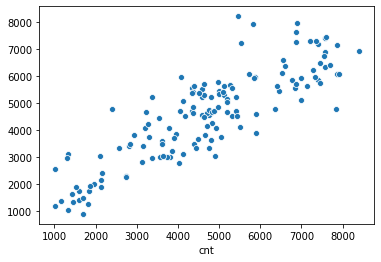

In [36]:
# View scatterplot of predicted values with actual values 
sns.scatterplot(y_test, linear_predict)



---


**Multiple linear regression Error matrix**





*   MAPE - 18.9614
*   MAE - 759.1427
*   r2_score -  0.7264
*   rmse -  972.8801


---







---


# **Random Forest**




In [0]:
# build random forest model
random_forest_model = RandomForestRegressor(n_estimators=125,).fit(X_train,y_train)

In [0]:
# predict using random model
random_forest_predict =  random_forest_model.predict(X_test)

In [39]:
# measure the goodness of a random forest model
print('mape : ',mape(random_forest_predict,y_test))
print('mae : ' ,mae(random_forest_predict,y_test))
print('r2_score:',r2_score(y_test,random_forest_predict))
print('rmse:',np.sqrt(mean_squared_error(y_test,random_forest_predict))) 

mape :  11.71077268852105
mae :  497.65044444444436
r2_score: 0.8688480268119025
rmse: 673.6840168367759


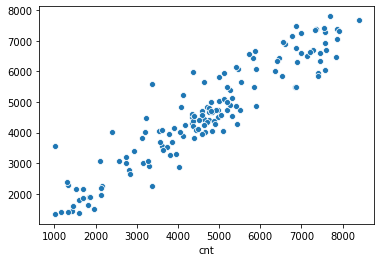

In [40]:
# View scatterplot of predicted values with actual values 
sns.scatterplot(y_test, random_forest_predict)



---


**Random forest matrix**


*   MAPE - 11.4862
*   MAE - 482.8005
*   r2_score: 0.8717
*   rmse: 666.3079



---





---
# **XGBoost model**


In [41]:
# build XGBoost Regressor model
xgb_model = xg.XGBRegressor(max_depth=8, min_child_weight=6, gamma=0.4, colsample_bytree=0.6, subsample=0.6)
xgb_model.fit(X,y)

[17:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.4,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=6, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [0]:
# predict using XGBRegressor model
xgb_predict = xgb_model.predict(X_test)

In [43]:
# measure the goodness of a XGBoost regressor model
print('mape : ',mape(y_test,xgb_predict))
print('mae : ' ,mae(y_test,xgb_predict))
print('r2_score:',r2_score(y_test,xgb_predict))
print('rmse:',np.sqrt(mean_squared_error(y_test,xgb_predict))) 

mape :  4.3941124786902614
mae :  167.1380009121365
r2_score: 0.985095430882383
rmse: 227.10596541613572


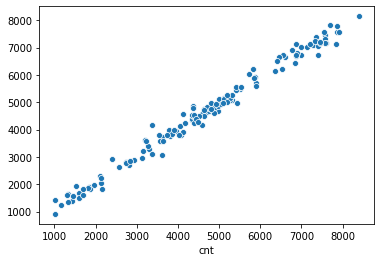

In [44]:
# View scatterplot of predicted values with actual values 
sns.scatterplot(y_test,xgb_predict)



---


**XGBoost regressor matrix**


* MAPE :  4.3941
* MAE :  167.1380
* r2_score: 0.9850
* rmse: 227.1059



---

